In [29]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
#import imageio
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
import math

SEED = 1234#固定种子，大家都可以重复结果
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True

xtrain = torch.unsqueeze(torch.linspace(-1, 1, 21), dim=1)
ytrain = torch.sin(math.pi*xtrain) + 0.2*torch.randn(xtrain.size())  # 这里是污染数据固定不变当成训练数据

#噪声注入输入数据方法
#对于训练数据ytrain
epoch = 20000 #一次训练步长数目

device = torch.device('cpu')#cpu计算
xtrain = xtrain.to(device)
ytrain = ytrain.to(device)

#测试数据
SEED = 666
torch.manual_seed(SEED)
torch.cuda.manual_seed_all(SEED)
np.random.seed(SEED)
random.seed(SEED) 
torch.backends.cudnn.deterministic = True
xtest = torch.unsqueeze(torch.linspace(-1, 1, 41), dim=1).to(device)
ytest = (torch.sin(math.pi*xtest) + 0.2*torch.randn(xtest.size())).to(device)

In [30]:
#reparameter method自适应选择sigma尝试
#上面噪声注入方法必须手动寻找，所以我们试试能够自适应寻找sigma最优值
#一种是optuna寻找，一种试试重参数方法，梯度学习寻找optima sigma

class SLF(nn.Module): #随机线性函数x+eta
    def __init__(self):
        super().__init__()
        self.sigma = nn.Parameter(torch.randn(1)) #可学习参数 sigma

    def forward(self, input):  
        output = input + torch.abs(self.sigma) * torch.randn_like(input) # 生成和输入相同形状的随机数
        return output


class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.SLFlayer = SLF()#相当于x+sigma*标准高斯分布
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.SLFlayer(x)
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x
    # def reset_parameters(self):
    #     # 重新初始化网络参数
    #     self.hidden1.reset_parameters()
    #     self.predict.reset_parameters()


#经典的sigmoid神经网络1*n_hidden1*1，中间隐层为sigmoid函数

net = Net(n_feature=1, n_hidden1=10, n_output=1)#定义1*10*1的网络
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))
#Adam算法，学习率是固定的0.01，矩参数是0.96
loss_func = torch.nn.MSELoss().to(device)  # loss函数是均方误差mse


In [31]:
z=net.SLFlayer.sigma#这样是找到网络模型net中custom1激活函数的参数sigma 
nn.init.constant_(z,0.1)#初始选择

Parameter containing:
tensor([0.1000], requires_grad=True)

In [38]:
#reparameter method自适应选择sigma尝试
#上面噪声注入方法必须手动寻找，所以我们试试能够自适应寻找sigma最优值
#一种是optuna寻找，一种试试重参数方法，梯度学习寻找optima sigma

epoch = 20000
para1 = torch.zeros(epoch)  # para1记录激活函数中学习参数sigma

for t in range(epoch):
    prediction1 = net(xtrain)
    prediction2 = net(xtest)
    loss = loss_func(prediction1, ytrain) + loss_func(prediction2, ytest) / loss_func(prediction1, ytrain)+ loss_func(prediction1, ytrain) / loss_func(prediction2, ytest) 
    #重要！！为啥选择这个loss，就是从泛化误差出发，loss= loss_train+ loss_test/loss_train+loss_train/loss_test
    #loss_train是要求变小从推动权系数更新，但是loss_test/loss_train+loss_train/loss_test（x+1/x）就是x=1最小，实际是一个正则化项
    #loss_test=loss_train最小化后面两项，又限制了权系数和sigma的变化
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    # 每隔 200 步打印一次 exp(sigma) 的值以及 loss
    if t % 200 == 0:
        print(f"Step {t}: Sigma = {torch.abs(net.SLFlayer.sigma).item()}, Loss = {loss.item()}")
    
    # 记录 exp(sigma) 的值
    para1[t] = torch.abs(net.SLFlayer.sigma).item()

Step 0: Sigma = 0.005984639748930931, Loss = 2.0614445209503174
Step 200: Sigma = 0.0025192678440362215, Loss = 2.0328023433685303
Step 400: Sigma = 0.004445571452379227, Loss = 2.082000732421875
Step 600: Sigma = 0.0002996513503603637, Loss = 2.032285213470459
Step 800: Sigma = 0.011338950134813786, Loss = 2.0545005798339844
Step 1000: Sigma = 0.0009909005602821708, Loss = 2.0387208461761475
Step 1200: Sigma = 0.005639190785586834, Loss = 2.050340414047241
Step 1400: Sigma = 0.0022530839778482914, Loss = 2.0330452919006348
Step 1600: Sigma = 0.0012844789307564497, Loss = 2.035926580429077
Step 1800: Sigma = 0.017789805307984352, Loss = 2.131073236465454
Step 2000: Sigma = 0.0007574600167572498, Loss = 2.035121440887451
Step 2200: Sigma = 0.0030520923901349306, Loss = 2.0632781982421875
Step 2400: Sigma = 0.004362254403531551, Loss = 2.033158779144287
Step 2600: Sigma = 0.003085686359554529, Loss = 2.0323872566223145
Step 2800: Sigma = 0.014148009940981865, Loss = 2.0432002544403076
St

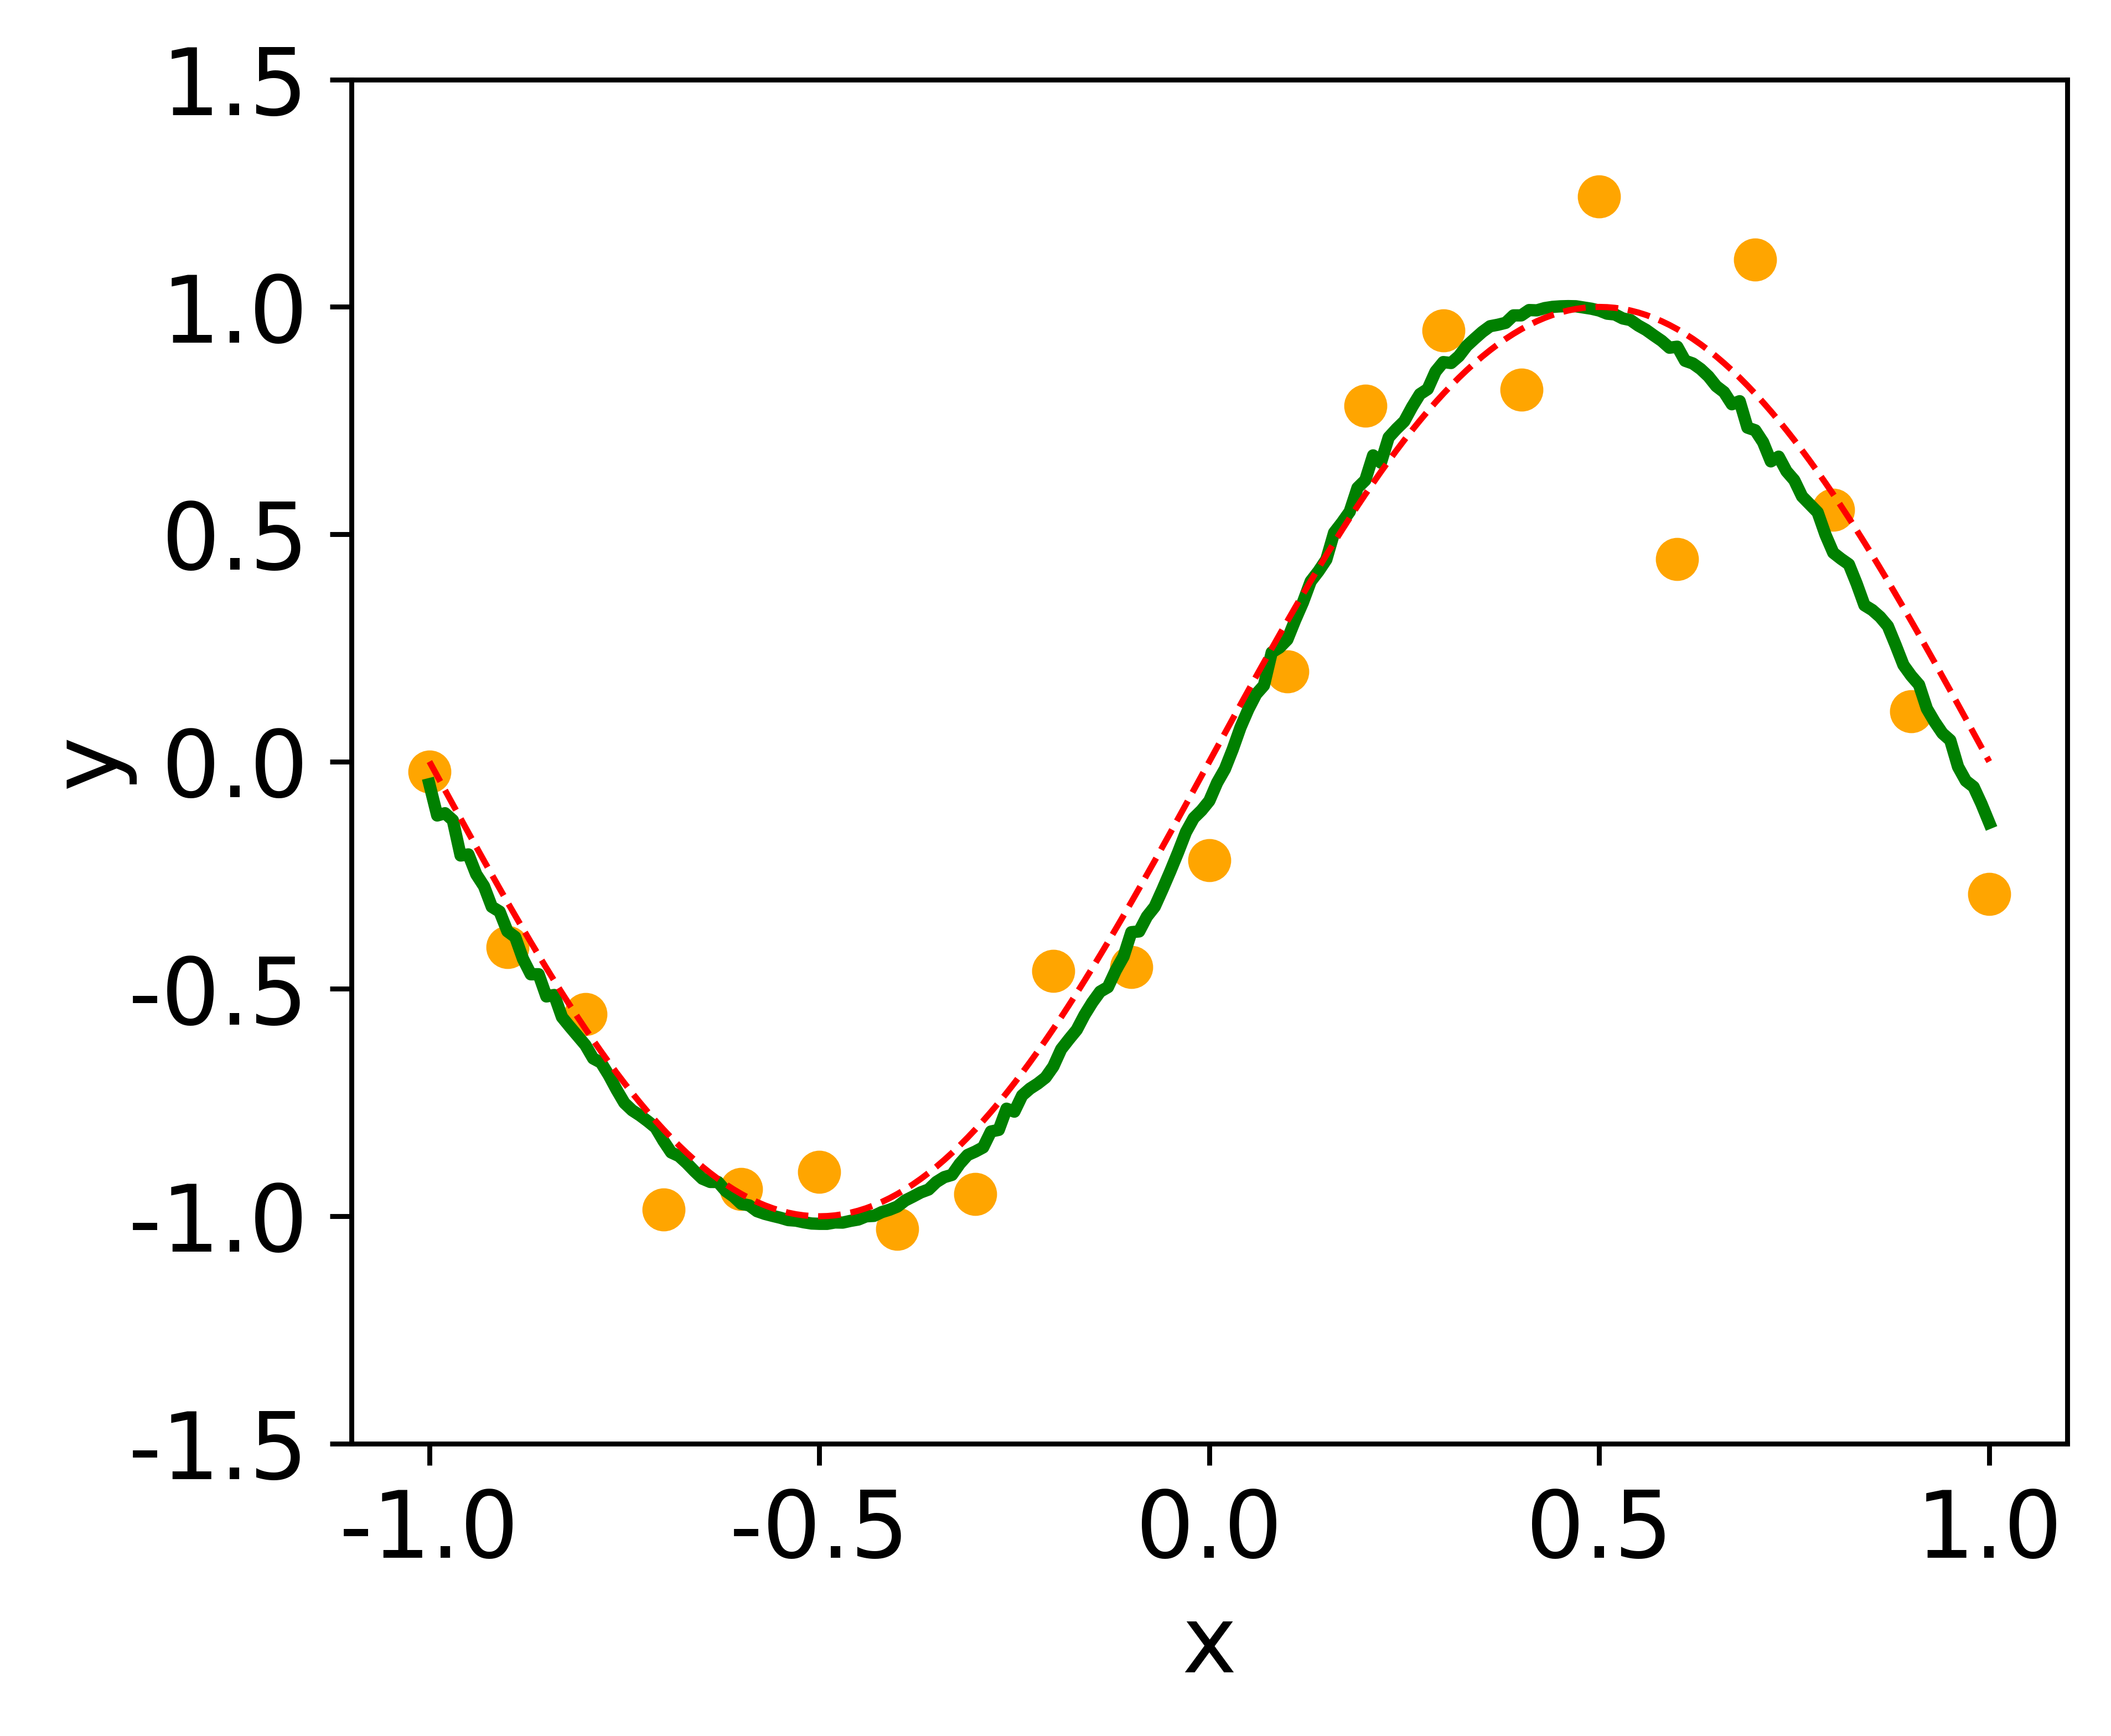

In [39]:
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)
# 画出训练集来，是橘色的散点。
ax.scatter(xtrain.data.numpy(), ytrain.data.numpy(), color="orange")
input = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
output = net(input)  # 非常密的输入和网络输出
ax.plot(input.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*input)
ax.plot(input.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

In [40]:
prediction1 = net(xtrain)
prediction2 = net(xtest)

In [41]:
loss_func(prediction1, ytrain)

tensor(0.0306, grad_fn=<MseLossBackward0>)

In [42]:
loss_func(prediction2, ytest)

tensor(0.0309, grad_fn=<MseLossBackward0>)

In [43]:
#重参数法，泛化误差很小，就是网络输出不够圆滑

In [44]:
#但是非常有效，实际上1000步即可，和我们设计的激活函数调参差不多步数

In [45]:
#sigma几乎是0，那么可能是loss设计的好处，并不是sigma噪声加入的好处
#我们验证一下

In [50]:
import random
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn as nn
import pandas as pd
#import imageio
import numpy as np
import torch
from torch.autograd import Variable
import torch.nn.functional as F
import torch.utils.data as Data

import matplotlib.pyplot as plt
%matplotlib inline
import math

In [51]:
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x
#经典的sigmoid神经网络1*n_hidden1*1，中间隐层为sigmoid函数

In [52]:
net = Net(n_feature=1, n_hidden1=10, n_output=1)
device = torch.device('cpu')#cpu计算就足够了，不是图像数据，所以不用GPU
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))

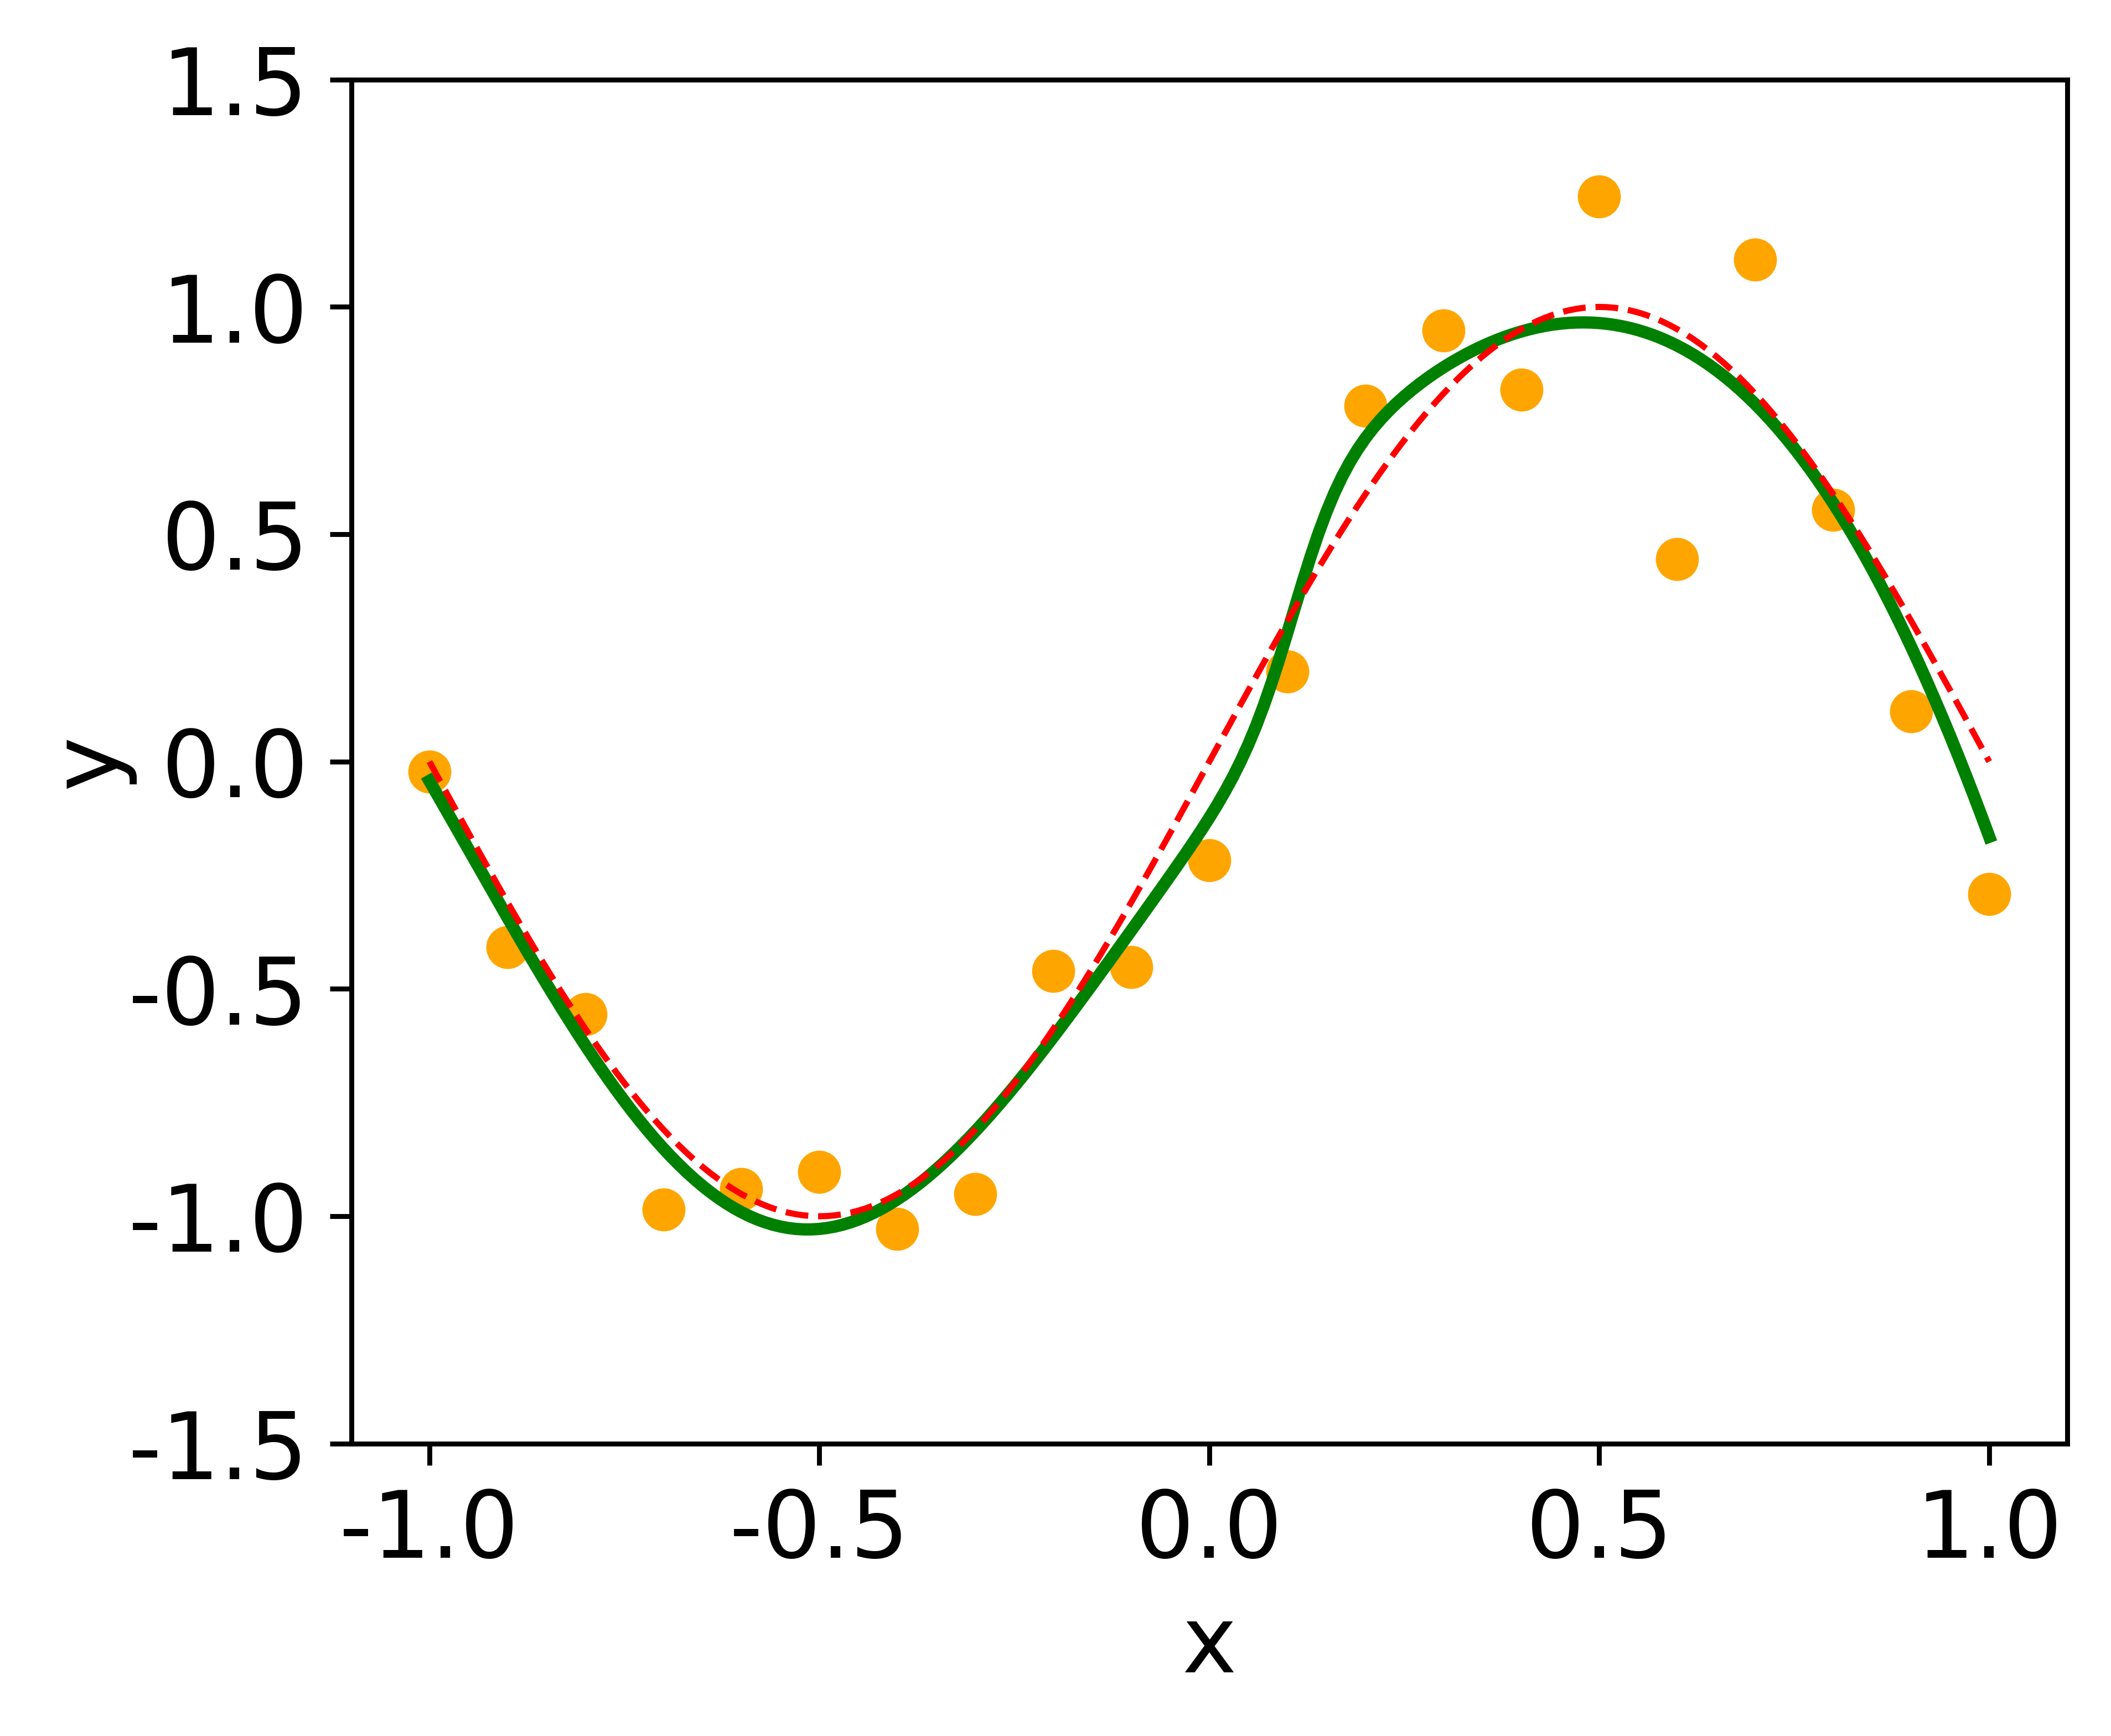

In [53]:
epoch = 20000#训练次数2万次

for t in range(epoch):
   
    prediction1 = net(xtrain)  # 网络前向过程
    prediction2 = net(xtest)
    loss = loss_func(prediction1, ytrain) + loss_func(prediction2, ytest) / loss_func(prediction1, ytrain)+ loss_func(prediction1, ytrain) / loss_func(prediction2, ytest) 
    
    
    optimizer.zero_grad()   # clear gradients for next train
    loss.backward(retain_graph=True)         # 反向传播！
    optimizer.step()        # 更新参数！


#画出网络学习曲线
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)

# 训练集橘色的散点
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange")
#网络拟合输出
input = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
output = net(input)  # 非常密的输入和网络输出
ax.plot(input.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*input)
ax.plot(input.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

In [55]:
#so, 可以看出是loss设计的技巧，不是加入噪声的原因
#这就是可以看成一种正则化方法也可以防止过拟合，能够达到拟合光滑的效果，当然效果还是不如我们设计的激活函数

In [56]:
#实际的正则化应该不用测试数据，如下实验

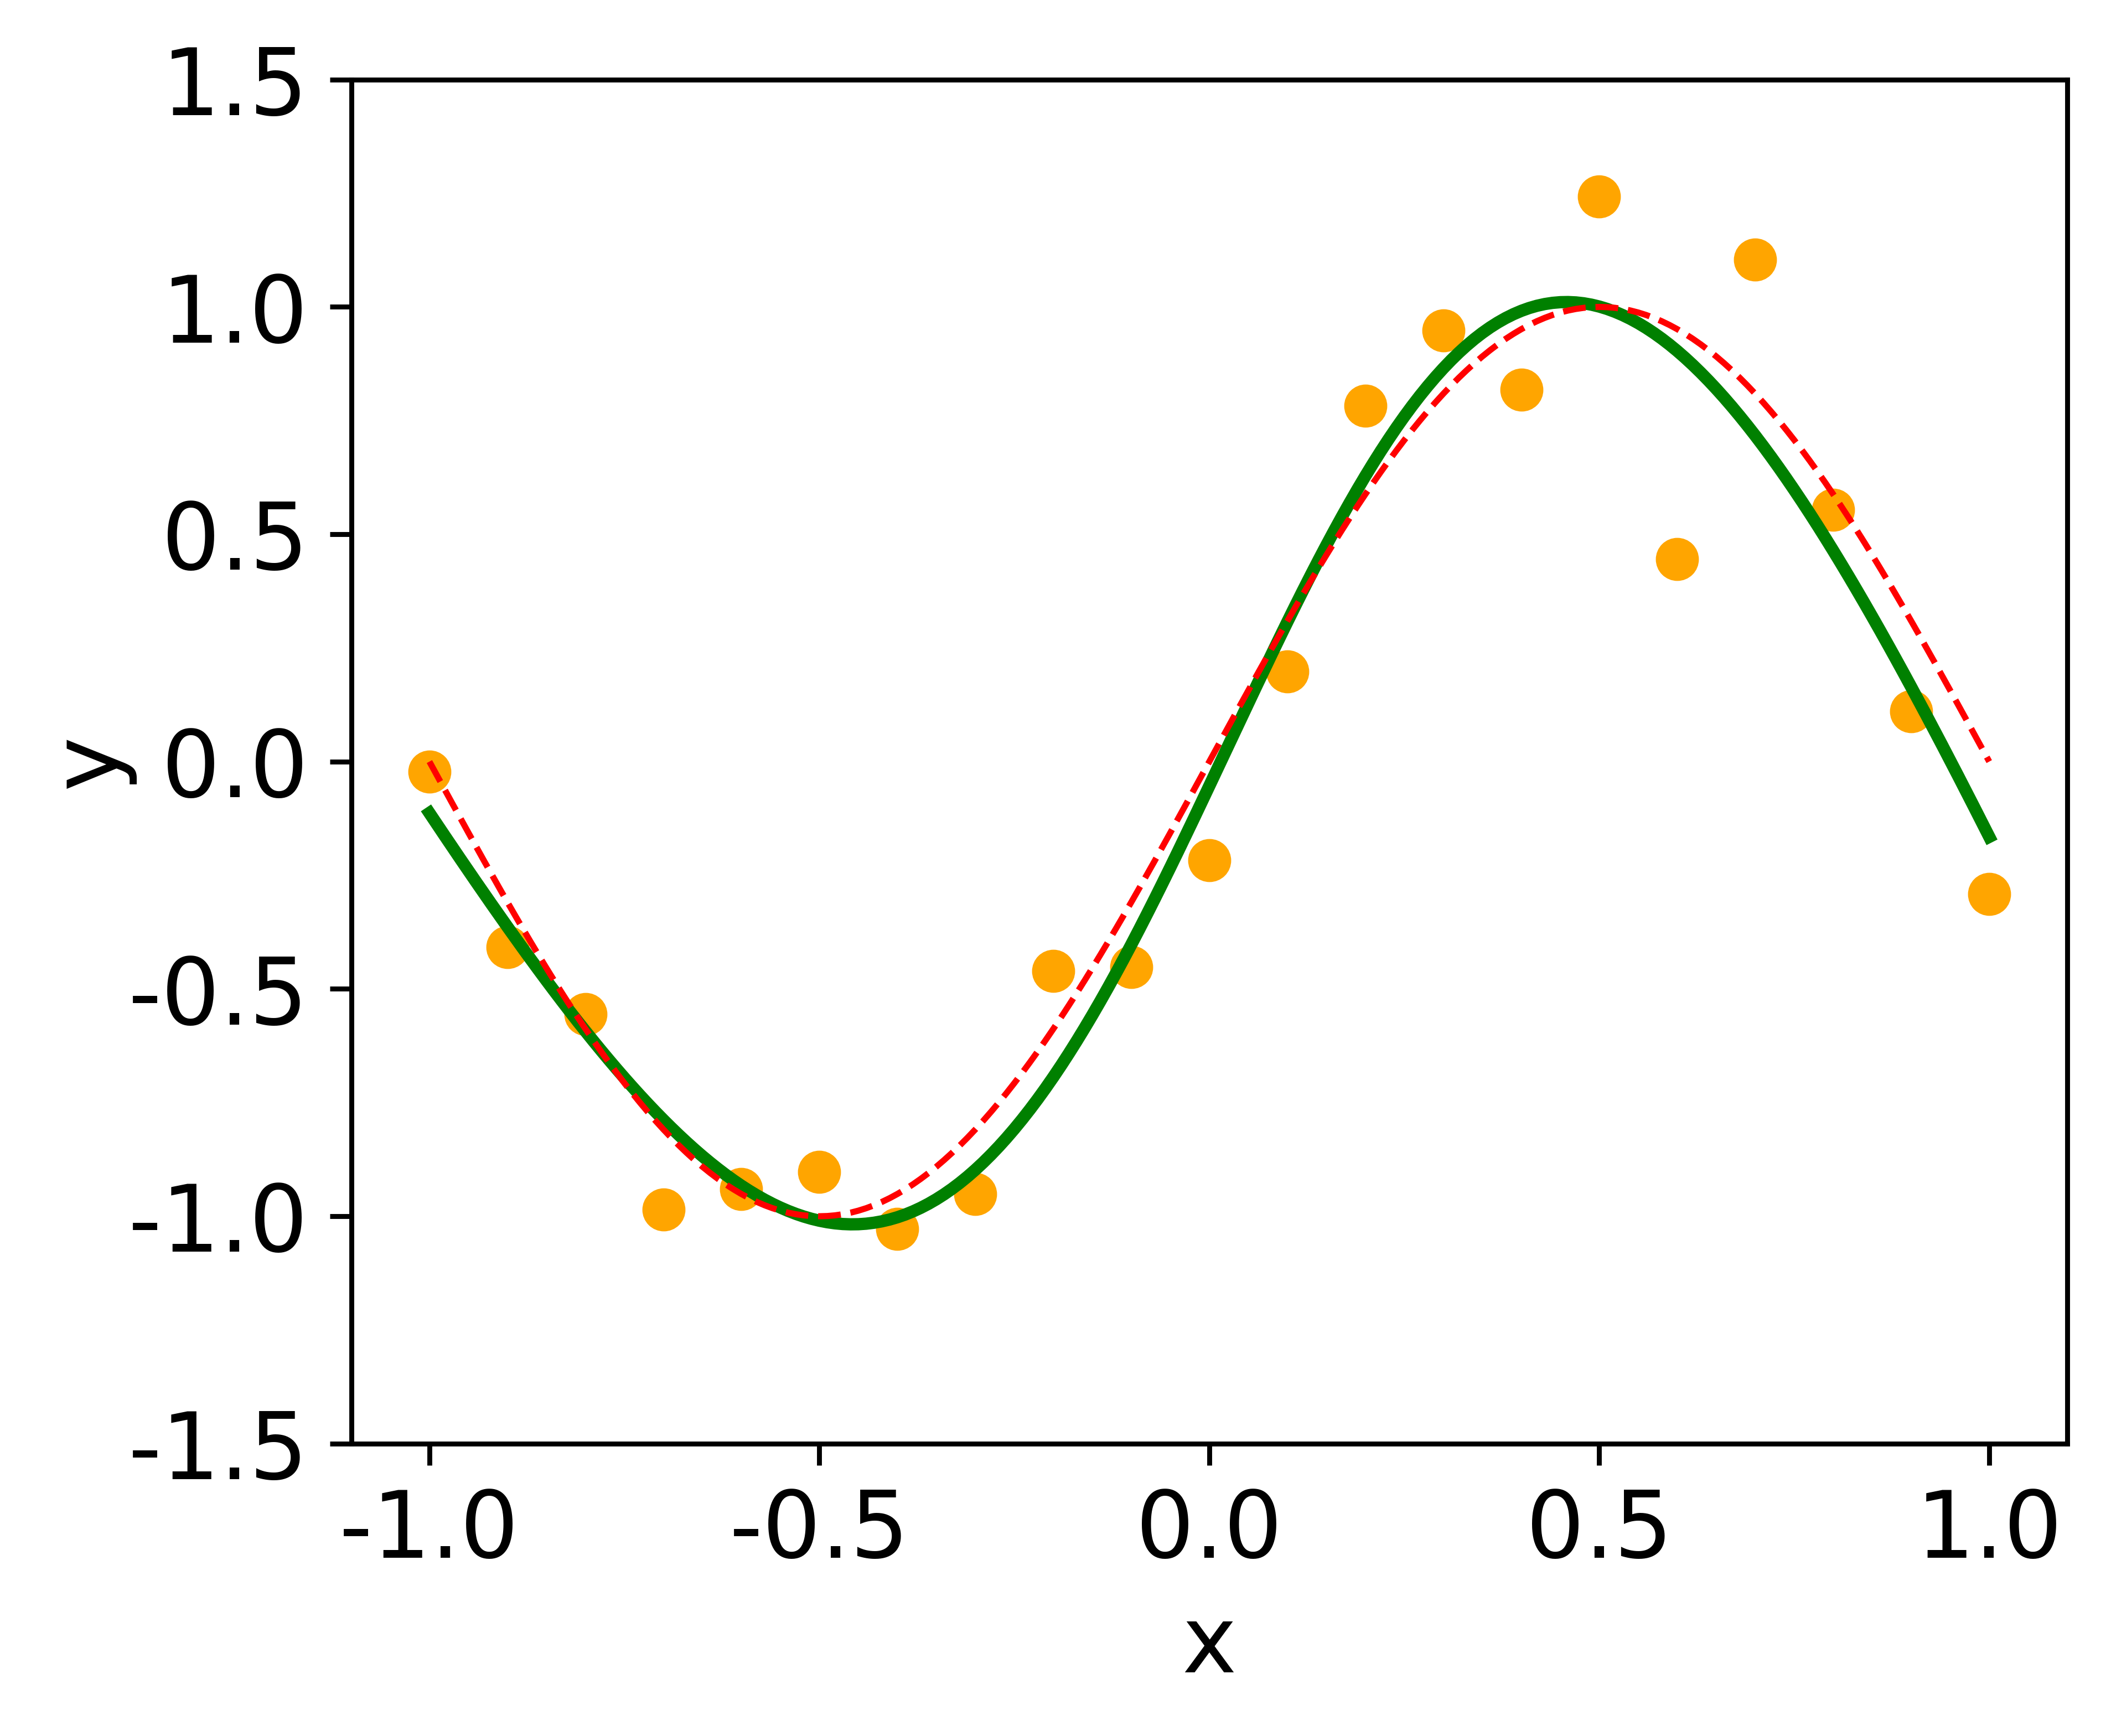

In [60]:
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x
net = Net(n_feature=1, n_hidden1=10, n_output=1)
device = torch.device('cpu')#cpu计算就足够了，不是图像数据，所以不用GPU
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))

lambdaw=0.001#正则化系数

for t in range(epoch):
    prediction = net(xtrain)  # 网络前向过程
    loss = loss_func(prediction, ytrain)  # 计算总损失
    
    # 添加正则化项
    regularization_loss = torch.tensor(0.)  # 初始化正则化损失
    for param in net.parameters():
        regularization_loss += torch.norm(param, p=2)  # L2范数作为正则化项
        
    # 将正则化损失添加到总损失中
    total_loss = loss + lambdaw*regularization_loss    
    
    optimizer.zero_grad()  # 清除梯度
    total_loss.backward()  # 反向传播
    optimizer.step()  # 更新参数

#画出网络学习曲线
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)

# 训练集橘色的散点
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange")
#网络拟合输出
input = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
output = net(input)  # 非常密的输入和网络输出
ax.plot(input.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*input)
ax.plot(input.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

In [64]:
#传统的正则化也非常好，但是正则化系数需要谨慎选择
#比如下面lambdaw=0.1#正则化系数

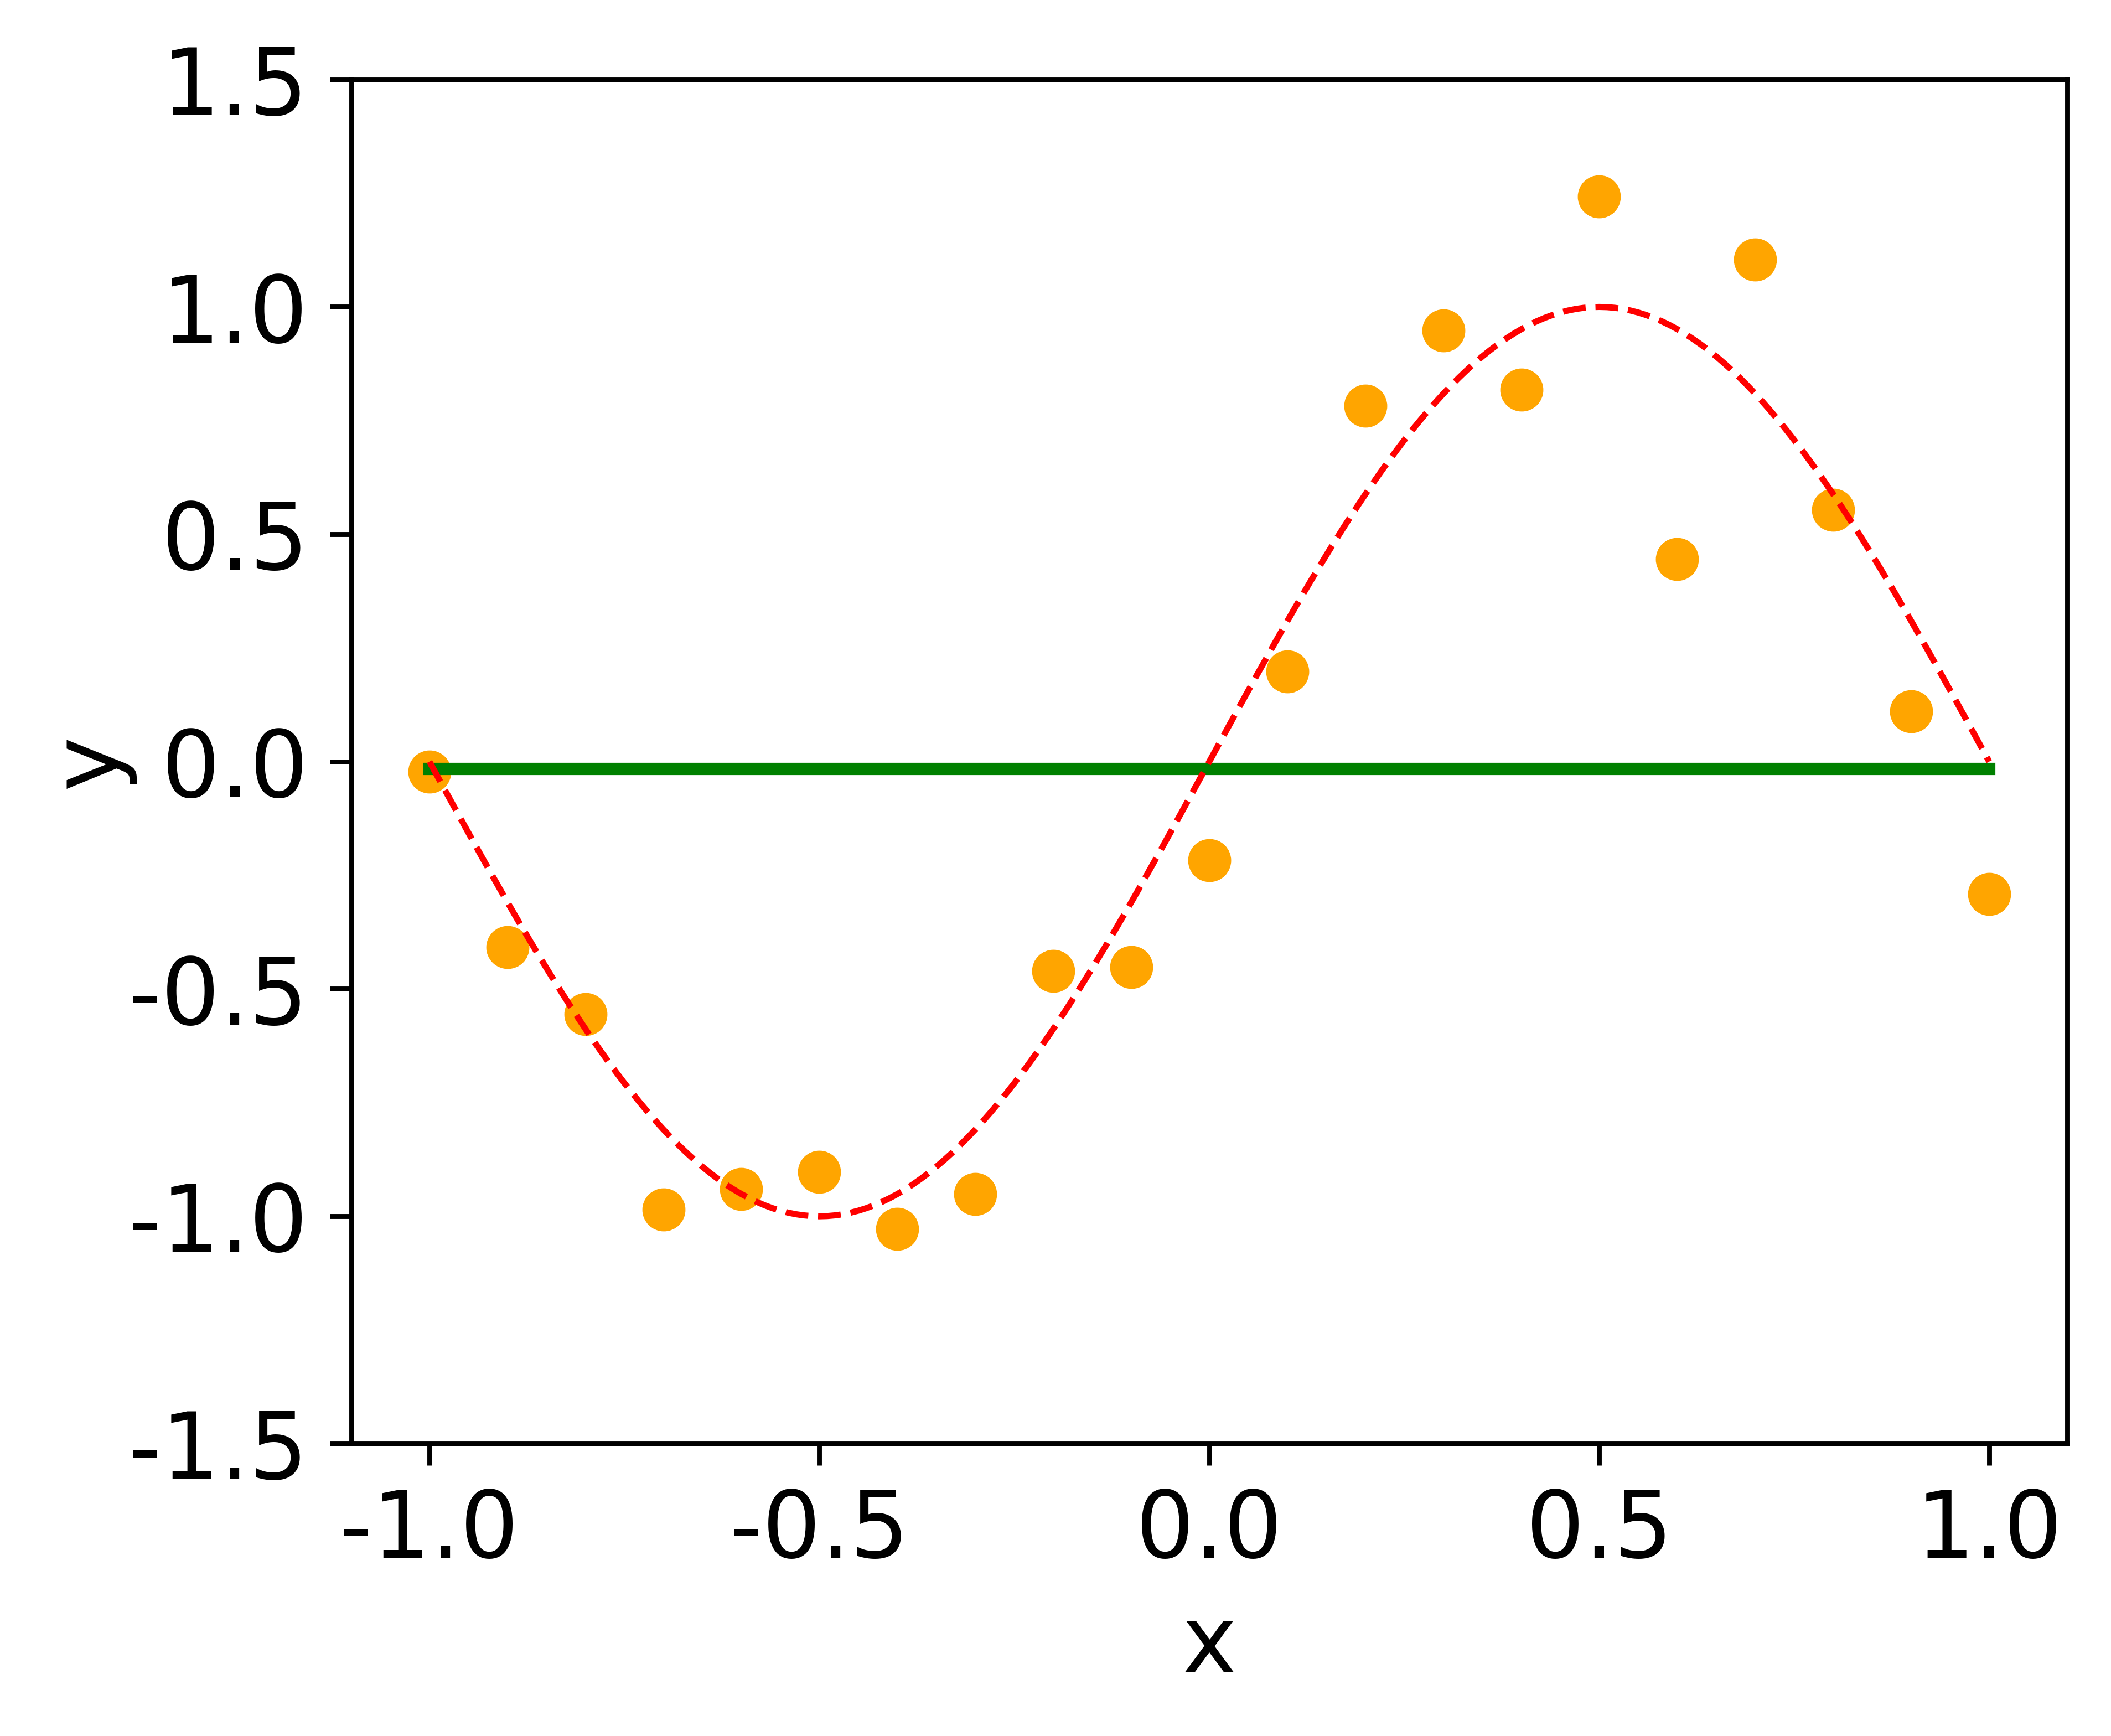

In [65]:
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x
net = Net(n_feature=1, n_hidden1=10, n_output=1)
device = torch.device('cpu')#cpu计算就足够了，不是图像数据，所以不用GPU
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))

lambdaw=0.1#正则化系数

for t in range(epoch):
    prediction = net(xtrain)  # 网络前向过程
    loss = loss_func(prediction, ytrain)  # 计算总损失
    
    # 添加正则化项
    regularization_loss = torch.tensor(0.)  # 初始化正则化损失
    for param in net.parameters():
        regularization_loss += torch.norm(param, p=2)  # L2范数作为正则化项
        
    # 将正则化损失添加到总损失中
    total_loss = loss + lambdaw*regularization_loss    
    
    optimizer.zero_grad()  # 清除梯度
    total_loss.backward()  # 反向传播
    optimizer.step()  # 更新参数

#画出网络学习曲线
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)

# 训练集橘色的散点
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange")
#网络拟合输出
input = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
output = net(input)  # 非常密的输入和网络输出
ax.plot(input.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*input)
ax.plot(input.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

In [66]:
#正则化系数过大，直接不工作，取lambdaw=0.01#正则化系数

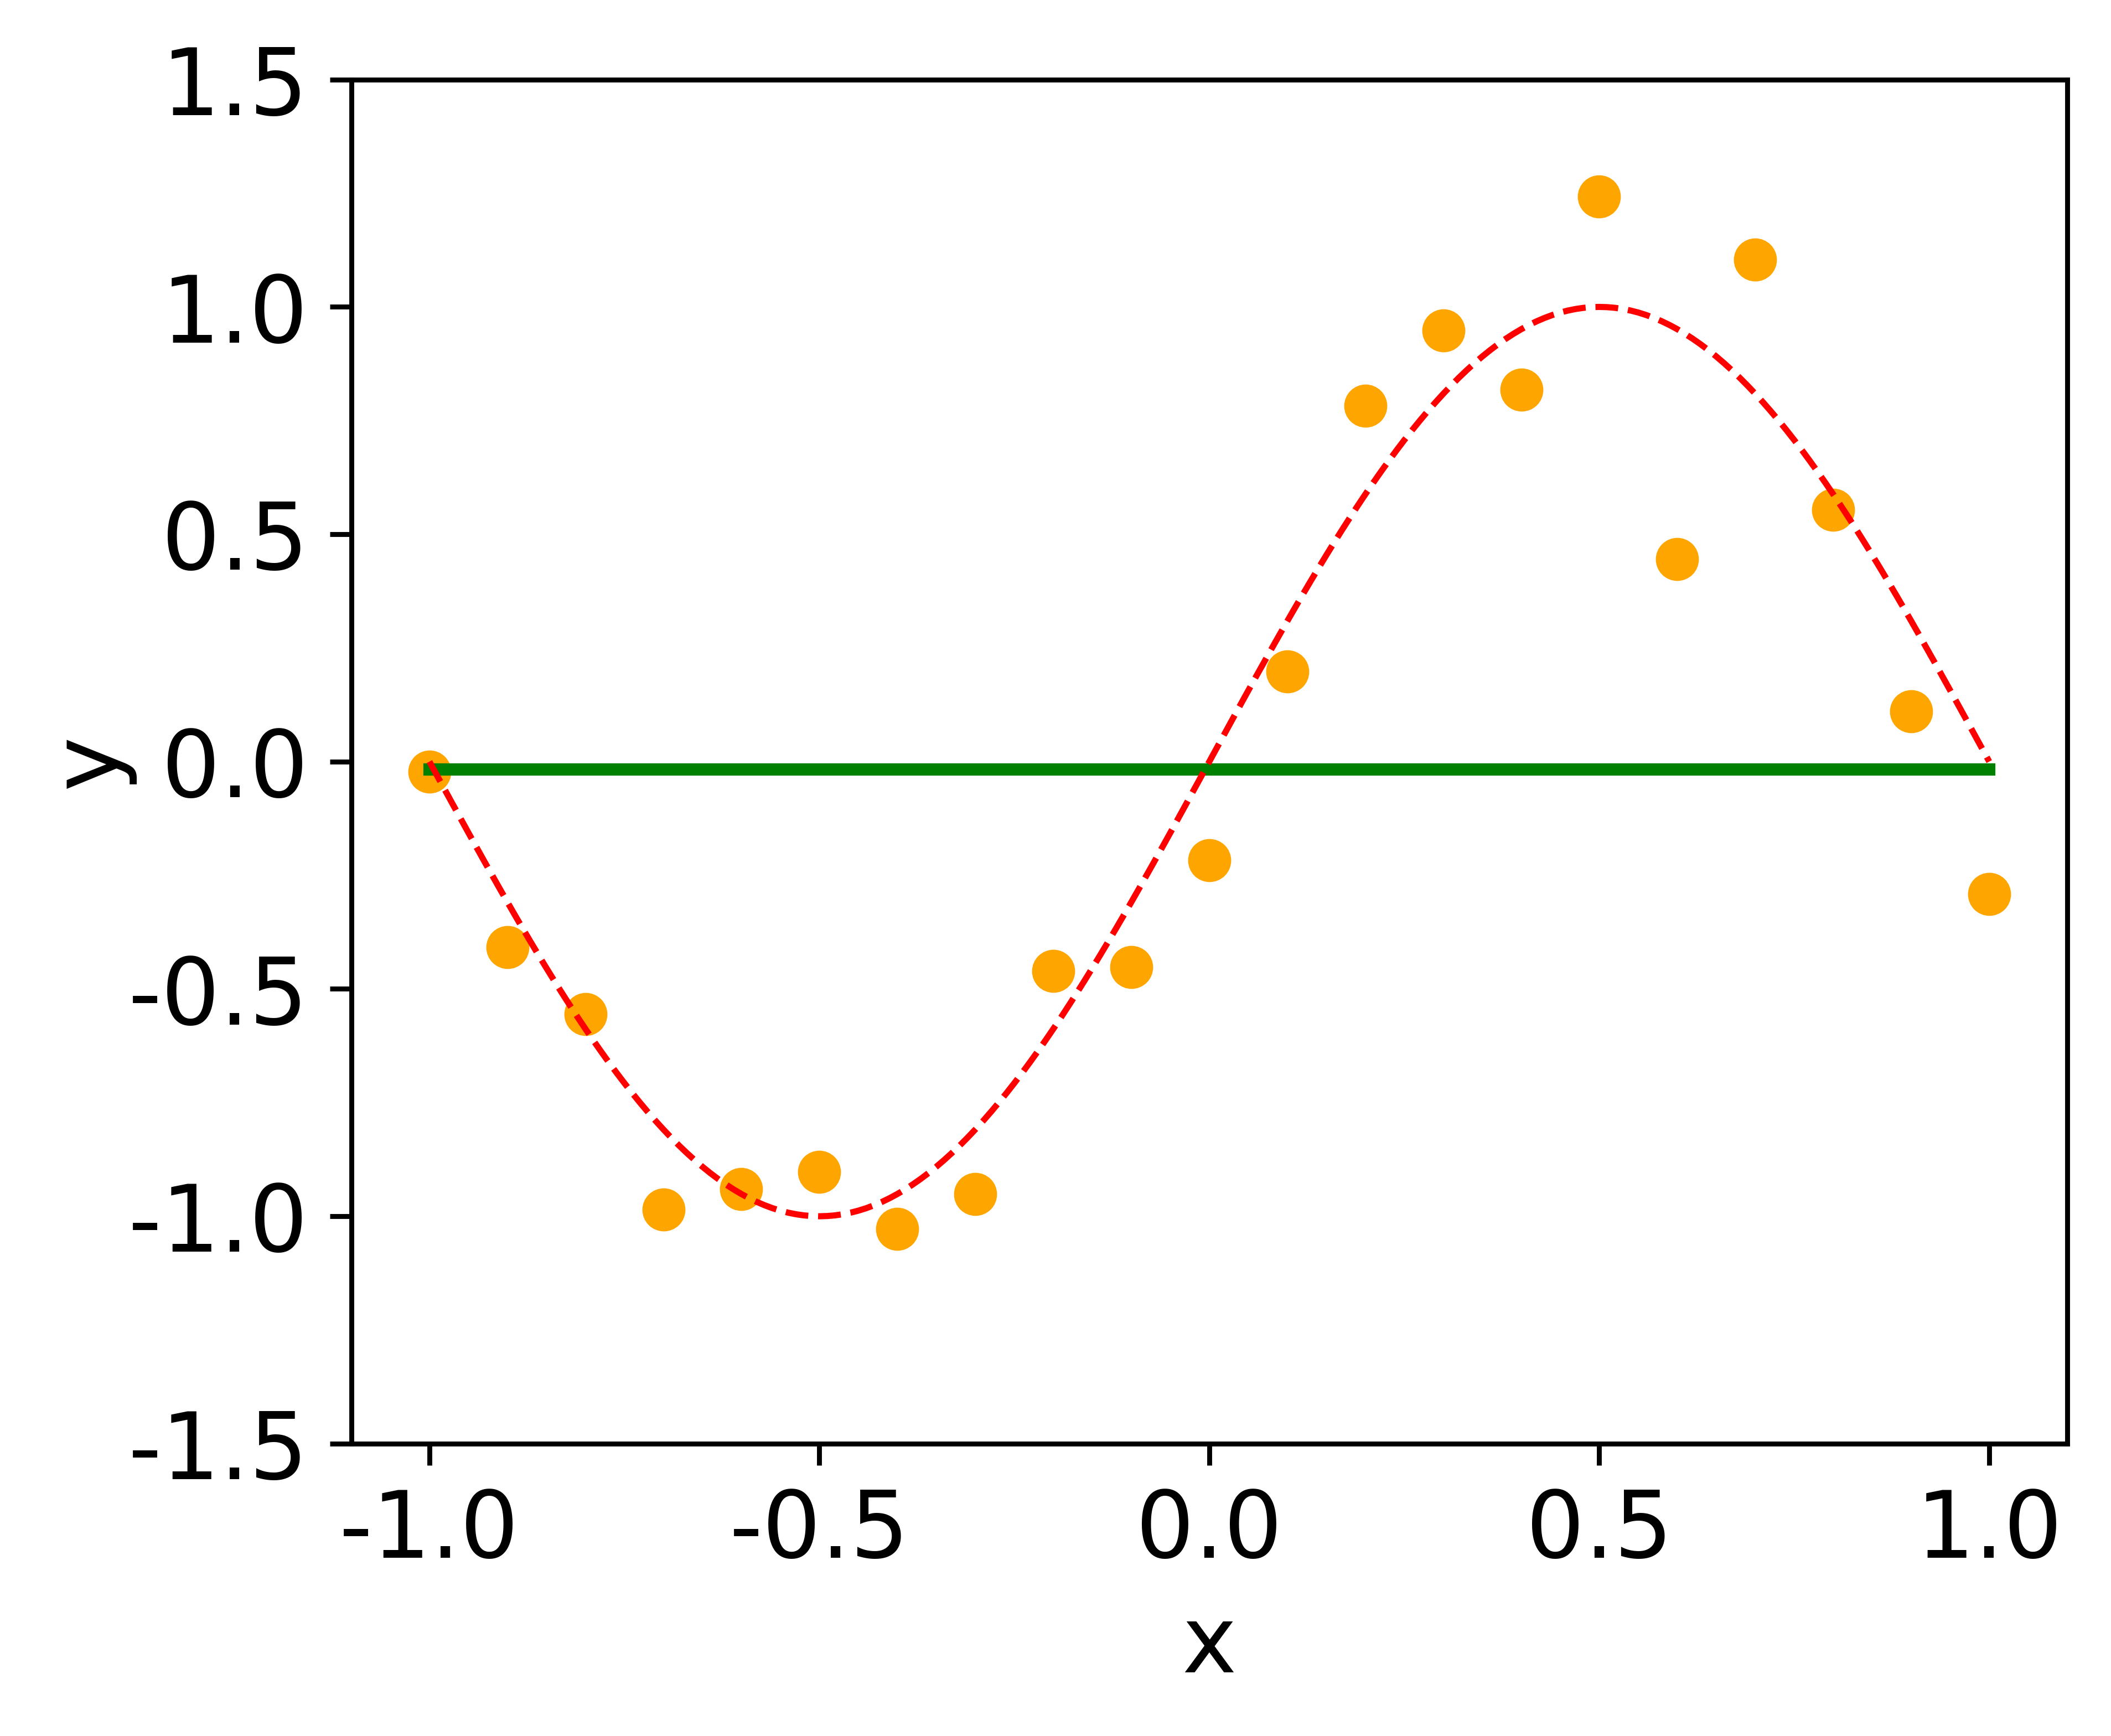

In [67]:
class Net(torch.nn.Module):  # 定义网络
    def __init__(self, n_feature, n_hidden1, n_output):
        super(Net, self).__init__()
        self.hidden1 = torch.nn.Linear(n_feature, n_hidden1)  # 全连接层
        self.predict = torch.nn.Linear(n_hidden1, n_output)   # 输出层

    def forward(self, x):
        x = self.hidden1(x)
        x = torch.sigmoid(x)
        x = self.predict(x)  # 前向传播过程
        return x
net = Net(n_feature=1, n_hidden1=10, n_output=1)
device = torch.device('cpu')#cpu计算就足够了，不是图像数据，所以不用GPU
optimizer = torch.optim.Adam(net.parameters(), lr=0.01,betas=(0.96,0.96))

lambdaw=0.1#正则化系数

for t in range(epoch):
    prediction = net(xtrain)  # 网络前向过程
    loss = loss_func(prediction, ytrain)  # 计算总损失
    
    # 添加正则化项
    regularization_loss = torch.tensor(0.)  # 初始化正则化损失
    for param in net.parameters():
        regularization_loss += torch.norm(param, p=2)  # L2范数作为正则化项
        
    # 将正则化损失添加到总损失中
    total_loss = loss + lambdaw*regularization_loss    
    
    optimizer.zero_grad()  # 清除梯度
    total_loss.backward()  # 反向传播
    optimizer.step()  # 更新参数

#画出网络学习曲线
import matplotlib.pyplot as plt
import matplotlib as mpl
plt.rcParams ['font.serif'] = ['Times New Roman']
mpl.rcParams['figure.dpi'] = 800
mpl.rcParams['axes.unicode_minus']=False  # #用来正常显示负号
#plt.style.use(['science','ieee'])#如果找不到science plot包则载入这句话
fig, ax = plt.subplots(figsize=(5,4)) 
plt.cla()
plt.tick_params(labelsize=15)
ax.set_xlabel('x', fontsize=15)
ax.set_ylabel('y', fontsize=15, labelpad = -1)
ax.set_xlim(-1.1, 1.1)
ax.set_ylim(-1.5, 1.5)

# 训练集橘色的散点
ax.scatter(x.data.numpy(), y.data.numpy(), color="orange")
#网络拟合输出
input = torch.unsqueeze(torch.linspace(-1, 1, 201), dim=1)
output = net(input)  # 非常密的输入和网络输出
ax.plot(input.data.numpy(), output.data.numpy(), 'g-', lw=2)
#真实信号
signal = torch.sin(math.pi*input)
ax.plot(input.data.numpy(), signal.data.numpy(), 'r--', lw=1,label='signal')

In [ ]:
#结果也不行，有时行，也不够接近真实信号，因此正则化系数如何选择又是个难题，还是不如我们she'j